<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [1]:
#%load_ext pycodestyle_magic
#%flake8_on
#import logging
#logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._ Goal is an introduction to deblender products. Some key points to hit: what is a parent, what is a child, describe a deblender, how does it work, what are we telling people about it. bunch of flags in object catalog that are already deblended. notebook can't fully be representative of all science cases for the deblender.

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

This notebook goals are to introduce deblender data products

what is a parent, what is a child, describe a deblender, how does it work, what are we telling people about it. bunch of flags in object catalog that are already deblended . notebook can't fully be representative of all science cases for the deblender.

Info from pipelines.lsst.io:
Seeded by the deepCoadd_mergeDet, the deblender works on each detection to find the flux in each component. The deblend subset produces the deepCoadd_deblendedFlux data product. The measure subset is responsible for measuring object properties on all of the deblended children produced by the deblender. This produces the deepCoadd_meas catalog data product with flux and shape measurement information for each object.

step 1: how to use deblender data prodcuts. Look through pipelines.lsst.io

step 2: reconfiguring deblender and running it can be stretch goal and / or followup tutorial


### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [2]:
# general python packages
import numpy as np
import os
import matplotlib.pyplot as plt
import gc
import time
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as Butler

# Familiar stack packages
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image, PARENT

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage
from lsst.afw.detection import MultibandFootprint, Footprint

# LSST package for image display
import lsst.afw.display as afwDisplay
#import lsst.geom
import lsst.geom as geom

# Astropy imports
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import make_lupton_rgb
from photutils import * #SkyCircularAperture
from astropy.nddata import Cutout2D

# Pipeline tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
afwDisplay.setDefaultBackend('matplotlib')

### 1.2 Define Functions and Parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

In [3]:
# A function and settings  to plot a cutout from tutorial notebook 03a

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

# prepare to do the cutout from tutorial notebook 03
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

def heavyFootprintToImage(heavy, fill=np.nan, bbox=None, imageType=MaskedImage):
    """Create an image of a HeavyFootprint
    Written by Fred Moolekamp from Data Management(?)
    Parameters
    ----------
    heavy : `HeavyFootprint`
        The HeavyFootprint to insert into the image
    fill: number
        Number to fill the pixels in the image that are not
        contained in `heavy`.
    bbox : `Box2I`
        Bounding box of the output image.
    imageType : `type`
        This should be either a `MaskedImage` or `Image` and describes
        the type of the output image.
    Returns
    -------
    image : `lsst.afw.image.MaskedImage` or `lsst.afw.image.Image`
        An image defined by `bbox` and padded with `fill` that
        contains the projected flux in `heavy`.
    """
    if bbox is None:
        bbox = heavy.getBBox()
    image = imageType(bbox, dtype=heavy.getImageArray().dtype)
    image.set(fill)
    heavy.insert(image)
    return image

## 2. Deblender data products

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Finding a heavily blended source in the LSST data

_There are efficient and non-efficient ways to search the LSST data for objects with certain characteristics, such as by how many sources are blended together. The pipeline records a number of keywords that can be used to identify and characterize blended sources that have been deblended that are stored in the object and source tables. Some examples:

detect_isPrimary 	True if source has no children, is in inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter (see config.pseudoFilterList)

deblend_skipped 	Deblender skipped this source

detect_fromBlend 	This source is deblended from a parent with more than one child.

detect_isDeblendedModelSource 	True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter (see config.pseudoFilterList) and is a deblended child

parentObjectId 	Unique ID of parent source. Reference band.

detect_isDeblendedSource 	True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter (see config.pseudoFilterList) and is either an unblended isolated source or a deblended child from a parent with

footprintArea  	Number of pixels in the sources detection footprint. Reference band.

These can be accessed via TAP queries, or through the butler, so we will demonstrate both. However, in both cases, one must first identify the region of the sky to search and search in a specific region defined by RA/Dec within a certain search radius or patch/tract. This is because the databases are indexed by RA/Dec and searching by blending keywords (i.e. to identify the most blended sources or by parent object ID) are extremely inefficient_


In [4]:
# open TAP service
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# initialize Butler
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)


In [5]:
#%%time
# Identify some examples of very blended sources
# THIS IS TOO SLOW (run time approx 15 min), but we show an example of what happens if you perform
# a TAP query and do not search within an specified coordinate range. 

#query = "SELECT TOP 10 objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
#        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
#        "tract, patch " + \
#        "FROM dp02_dc2_catalogs.Object " + \
#        "WHERE deblend_nChild > 12 AND  detect_fromBlend = 1 " #This source is deblended from a parent with more than one child

#max_rec = 50
#results_maxblend = service.search(query)#, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
#tab_maxblend = results_maxblend.to_table()
#tab_maxblend 


# This is very slow. TAP is optimized to search on RA / Dec not other stuff. Do not use.


In [6]:
%%time
# instead, if you can identify a region of the sky first then the query is faster.
# Here we have already identified a region with an example of a blend of 12 sources
# (using the long search above) as an example to demonstrate the deblended data 
# products produced by the pipeline

# Choose a parent and deblended children. Here are a couple good ones:
#1329731770446283558	4574.5498478	5486.0082516	72.3165407	-42.8674071	True	0	False	True	True	True	False	1329731770446253832	4867	0.9493601	3085	8
#1248675773246610542	23484.4969535	3210.1552014	50.1089143	-44.4812763	False	13	False	False	False	False	False	0	3435	0.0	2897	5

tract = 2897
patch = 5

sel_objid = 1248675773246610542 
ra = 50.1089143
dec = -44.4812763
x = 23484.4969535
y = 3210.1552014


# TAP catalogs are indexed by RA/Dec and searching based on IDs or other properties are
# super inefficient. One option is to first search on RA/Dec and then use a where statement 
# to pull out targets based on ID  

query_children = "SELECT ObjectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.01)) = 1 "   
    
results_children = service.search(query_children, maxrec=10000)
tab_children = results_children.to_table()


# print out the output

whc = np.where(tab_children['parentObjectId'] == sel_objid)[0]
#tab_children[whc]

CPU times: user 34.9 ms, sys: 2.17 ms, total: 37 ms
Wall time: 1min 36s


In [14]:
%%time
# Next, demonstrate how to do this using the Butler

obj = butler.get('objectTable',  tract=tract, patch=patch)
print(f"Retrieved catalog of {len(refTable)} objects.")
#refTable.schema.find('detect_isPrimary')
#refTable.schema.getNames() # can you add a wildcard here to search keywords including "blend"

obj_parentObjectId = np.asarray(obj.parentObjectId, dtype='int')
obj_objectId = np.asarray(obj.index, dtype='int')
obj_coord_x = np.asarray(obj.x, dtype='float')
obj_coord_y = np.asarray(obj.y, dtype='float')
obj_ra = np.asarray(obj.coord_ra, dtype='float') # CHECK THESE ARE THE RIGHT ONES
obj_dec = np.asarray(obj.coord_dec, dtype='float')

#ids = refTable.index.to_numpy()
#ras = refTable.coord_ra.to_numpy()
#decs = refTable.coord_dec.to_numpy()

# Pull out all of the sources that are blended with our chosen source as the parent
wh = np.where(obj_parentObjectId == sel_objid )[0]
for i in wh:
    print(obj_parentObjectId[i], obj_objectId[i], obj_coord_x[i], obj_coord_y[i])
print('FOUND', len(wh), "sources blended with Parent ID sel_objid")
#print(obj_objectId[wh], [wh], decs[wh])

Retrieved catalog of 32101 objects.
1248675773246610542 1248675773246640703 23484.493982278047 3210.1595244834843
1248675773246610542 1248675773246640704 23466.9451451522 3233.6287998058606
1248675773246610542 1248675773246640705 23483.320008254163 3246.0487119002632
1248675773246610542 1248675773246640706 23512.9343388915 3205.7072499403953
1248675773246610542 1248675773246640707 23455.400666064994 3242.1856875225335
1248675773246610542 1248675773246640708 23488.07512761676 3231.692096689908
1248675773246610542 1248675773246640709 23459.093178291714 3230.9886405112957
1248675773246610542 1248675773246640710 23495.101275324098 3184.438564042999
1248675773246610542 1248675773246640711 23502.63552370019 3188.5572090849855
1248675773246610542 1248675773246640712 23465.71870790558 3197.3916488116315
1248675773246610542 1248675773246640713 23478.921981330524 3227.3238198632953
1248675773246610542 1248675773246640714 23503.206784555066 3201.591832926169
1248675773246610542 124867577324664071

#### What deblender results are available in the butler?

In [17]:
registry = butler.registry
for dt in sorted(registry.queryDatasetTypes('*blend*')):
    print(dt)

DatasetType('deblend_config', {}, Config)
DatasetType('deblend_log', {skymap, tract, patch}, ButlerLogRecords)
DatasetType('deblend_metadata', {skymap, tract, patch}, PropertySet)
DatasetType('deepCoadd_deblendedFlux', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedFlux_schema', {}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel_schema', {}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended_schema', {}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended_schema', {}, SourceCatalog)



#### 2.1.1 Displaying an example of a heavily blended source

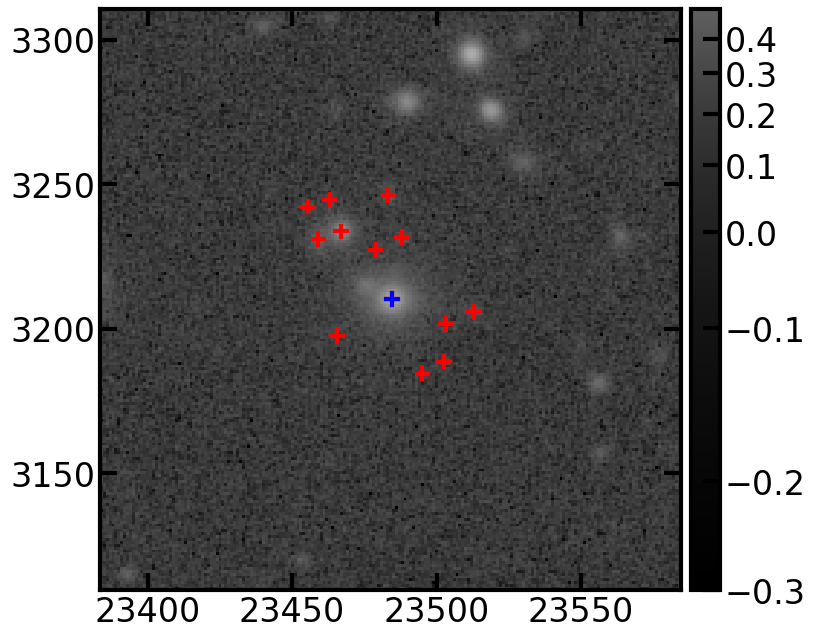

In [13]:
# prepare to do the cutout from tutorial notebook 03
cutout_image = cutout_coadd(butler, ra,dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=201)

wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())


fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(tab_children[whc])):
        display.dot('+', tab_children[whc][i]['x'], tab_children[whc][i]['y'], ctype=afwDisplay.RED)

display.dot('+', x, y, ctype=afwDisplay.BLUE)
plt.show()


DatasetType('deblend_config', {}, Config)
DatasetType('deblend_log', {skymap, tract, patch}, ButlerLogRecords)
DatasetType('deblend_metadata', {skymap, tract, patch}, PropertySet)
DatasetType('deepCoadd_deblendedFlux', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedFlux_schema', {}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel_schema', {}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended_schema', {}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended_schema', {}, SourceCatalog)


In [ ]:

# OLD STUFF STARTS HERE:




#center_coords = SkyCoord(55.6521739130, -31.9834710744, frame='icrs', unit='deg')
center_coords = SkyCoord(55.7393808,-32.2751775, frame='icrs', unit='deg')
search_radius = 10*u.arcmin

use_center_coords = "55.7393808, -32.2751775"
use_radius = "0.02"
 
max_rec = 10

query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND  detect_fromBlend = 1 " #This source is deblended from a parent with more than one child
        #"AND detect_isPrimary = 0 " #True if source has no children and is in the inner region of a coadd patch and is in the inner region of a coadd tract and is not detected in a pseudo-filter
        
results_notPrimary = service.search(query)#, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
tab_notPrimary = results_notPrimary.to_table()
#tab_notPrimary 


In [ ]:
query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isIsolated = 1"
#        "AND detect_isPrimary = 1 " # we want to remove this, make False to return blends

results_Isolated = service.search(query)#, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
tab_Isolated = results_Isolated.to_table()
#tab_notPrimary 

In [ ]:
query = "SELECT objectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 " # we want to remove this, make False to return blends

results_Primary = service.search(query)#, maxrec=max_rec)
#assert len(results1) == max_rec

# Convert the results to an Astropy table, then
#   take a look at the table.
tab_Primary = results_Primary.to_table()
#tab_notPrimary 

In [ ]:
# prepare to do the cutout from tutorial notebook 03
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)

dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
# Retrieve the data using the `butler` instance and its function `get()`
coadd = butler.get(datasetType, **dataId)

# First, we need to extract the WCS solution, which provides the mapping
#   between XY pixel values and sky coordinates:
wcs = coadd.getWcs()

# The cluster seems to be centered at about (X, Y) ~ (12500, 8500).
# We can use the "pixelToSky" method of the WCS to get the sky coordinates:
radec = wcs.pixelToSky(12500, 8500)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

# Select a position at roughly the center of the galaxy cluster:
cutout_image = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

# Display the image cutout
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with display.Buffering():
    for i in range(len(tab_notPrimary)):
        display.dot('+', tab_notPrimary[i]['x'], tab_notPrimary[i]['y'], ctype=afwDisplay.RED)
    for j in range(len(tab_Primary)):
        display.dot('o', tab_Primary[j]['x'], tab_Primary[j]['y'], size=20, ctype='orange')
    #for k in range(len(tab_Isolated)):
        #display.dot('^', tab_Isolated[k]['x'], tab_Isolated[k]['y'], ctype='blue')

plt.show()
#remove_figure(fig)

In [ ]:
# get info about your cutout
refTable = butler.get('deepCoadd_ref',  tract=4431, patch=17)
refTable.schema.find('detect_isPrimary')
#refTable.schema.getNames()


In [8]:


datasetType = "deepCoadd"


dataId = {'tract': tract, 'band': 'i', 'patch': patch }  
blend_coadd = butler.get(datasetType, **dataId)


# Take a look at the image of the patch
plt.figure(figsize=(30,30))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_cutout.getImage())


# Plot the "Parent" source:
afw_display.dot('o', x, y, size=50, ctype=afwDisplay.RED)


NameError: name 'my_cutout' is not defined

<Figure size 3000x3000 with 0 Axes>

<Figure size 800x800 with 0 Axes>

#### 2.1.2 Section most blended objects

In [ ]:
collection = '2.2i/runs/DP0.2'
datasetType = "deepCoadd"
config = "dp02"
dataId = {'tract': tab_maxblend['tract'][0], 'band': 'i', 'patch': tab_maxblend['patch'][0] }  
blend_coadd = butler.get(datasetType, **dataId)

# LOOK INTO THIS DEBLEND_METADATA MORE:
deblend_metadata = butler.get("deblend_metadata", **dataId)

# Take a look at the image of the patch
plt.figure(figsize=(30,30))
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(blend_coadd.getMaskedImage()) # what does getMaskedImage do?

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with afw_display.Buffering():
    for i in range(len(tab_maxblend)):
        afw_display.dot('+', tab_maxblend[i]['x'], tab_maxblend[i]['y'], ctype=afwDisplay.RED)


In [ ]:

# first search on RA/Dec and then use a where statement to pull out targets based on ID    
query_children = "SELECT ObjectId, x, y, coord_ra, coord_dec, detect_isPrimary, deblend_nChild, deblend_skipped, detect_fromBlend, " + \
        "detect_isDeblendedModelSource, detect_isDeblendedSource, detect_isIsolated, parentObjectId, footprintArea, z_blendedness, " + \
        "tract, patch " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec ), " + \
        "CIRCLE('ICRS', " + str(ra) + ", " + str(dec) + ", 0.01)) = 1 "   


In [ ]:
# A random assortment of useful notes:

#Recommended Search Parameter “detect_isPrimary = True”: A good default search query parameter 
# for the Object, Source, and ForcedSource catalogs is to set detect_isPrimary = True. 
# The detect_isPrimary parameter is True if a source has no children, is in the inner region of a 
#coadd patch, is in the inner region of a coadd tract, and is not “detected” in a pseudo-filter. 


#https://pipelines.lsst.io/modules/lsst.pipe.tasks/deblending-flags-overview.html

# Catalog are objects in each visit (not coadded)
# the DP0.2 Schema Browser is helpful:
# https://dm.lsst.org/sdm_schemas/browser/dp02.html
# .Source catalog properties related to blending:
# parentSourceId, blendedness_abs, blendedness_flag, blendedness_flag_noCentroid, blendedness_flag_noShape

# Object catalog is sources in the final catalog
# .Object properties related to blending:
# deblend_nChild, deblend_skipped, detect_fromBlend, detect_isDeblendedModelSource,
# detect_isDeblendedSource, detect_isIsolated, detect_isPrimary, parentObjectId, i_blendedness,
# i_blendedness_flag, r_blendedness, r_blendedness_flag, (ditto u,g,y,z)

# object can use colors in its deblender


# questions for melissa:
# - butler vs TAP for catalog access? when to use?
# butler is inefficient for catalog access because it returns all columns for everything in
# a track at once. This can be good for some circumstances, such as getting all objects
# inside an track/image. TAP is better for querying things that meet some criteria. 

# - is there a segmentation map somewhere that identifies the deblending mask?
# could be called "the footprint" see notebook 05 section 4. See also 
# https://github.com/LSSTScienceCollaborations/StackClub/blob/master/SourceDetection/Footprints.ipynb
# - Looks like detect_isDeblendedSource = 1 and detect_isPrimary = 1 return the same thing?

# action items:

# look in catalog and search for particular sources that have many blends (DP0.2 doesn't
# have low z big galaxies, only 6 years of data and also because cosmology focused 
# simulation).

# go through notebook5 and learn what it is doing. this will inform stretch activities
# for this notebook. We are not yet sure what the user-tunable parameters for the 
# deblender are, so we have to find them another way. Then we will have meeting with 
# Fred about deblender later. 

# scarlet is imbedded in lsst pipelines, but ALex's notebooks are a few years old so
# are many pipeline versions ago. It is now in the pipeline. I should not have to install
# it for myslef. Can look at what scarlet config params those old notebooks tweaked
# can be used to map into the lsst science pipeline framework (might be called something
# different etc).

# maybe (at the end) even re-run the deblender with different parameters (stretch goal)
# deblend is also done in notebook 05 but none of the parameters are changed. So here if 
# we get to the poitn where we can see what the user-changable parameters are, we could
# do a couple of demos. 

# in the geoviews jira ticket, just keep a log of what you did (i.e. can't find example
# of any astro applications of it). Since Keith (or Leanne?) suggested it we could also close the loop
# with him and ask if he had any examples in mind or has he seen it. Can a convenient
# astropy package for this already exist?

# Questions for Melissa week of Nov 8:
# - I think what I'm looking for here is what children belong to the same deblend.
# - cant figure out how to grab a set of blends from the same deblended object
# - can't figure out how to extract a footprint for a coadd without running the deblender again (see https://github.com/LSSTScienceCollaborations/StackClub/blob/master/SourceDetection/Footprints.ipynb)
# - what does getMaskedImage do?
# mask plane may contain (flags bad pixels, detection)
# - Struggling with accessing Footprint and MultibandFootprint (class in afw). How to use, are there leftover data products or does detection have to be run?
# in notebook 4b there's a way to say tell me everything accessible by butler. there are possibly no image metadata 
# avail from deepcoadd (since this product of deblender comes after deepcoadd is generated).
# deblend_metadata is a property set

# https://github.com/lsst/afw/blob/main/doc/lsst.afw.multiband/multiband.rst

#geoviews: look in the way of whether things look nice? or fast at rendering ? what is the thing that makes it cool.

# Suggestions Nov 17 for science application:
#do we know if the parent has a non-deblended flux
#merger fractions as fn of redshift? or host identification for time domain
#can you select on children that have different colors than parent? 


# - what does AFW stand for? soemthing frameworks
# Explore deblend_metadata
#help(blend_coadd)
#deblend_metadata = butler.get("deblend_metadata", **dataId)
#help(deblend_metadata) is basically useless info